In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# parser for reading data in .tfrecord format.
def parser(serialized_example):
    feature_set = {'image': tf.FixedLenFeature([], tf.string),
                   'label': tf.FixedLenFeature([], tf.int64)}
    features = tf.parse_single_example(serialized_example, features= feature_set)
    image = tf.decode_raw(features['image'], tf.uint8)
    HEIGHT = 32
    WIDTH = 32
    DEPTH = 3
    image.set_shape([DEPTH * HEIGHT * WIDTH])
    image = tf.cast(tf.transpose(tf.reshape(image, [DEPTH, HEIGHT, WIDTH]), [1, 2, 0]), tf.uint8)
    label = tf.cast(features['label'], tf.int32)
    return image, label

In [3]:
# get labels for all training data.
filenames = "./data/cifar-10-data-im-0.02/train.tfrecords"
labels = []
batch_size = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    files = tf.data.Dataset.list_files(filenames)
    dataset = files.interleave(tf.data.TFRecordDataset, cycle_length=1)
    dataset = dataset.map(map_func=parser)
    dataset = dataset.batch(batch_size=batch_size)
    
    iterator = dataset.make_one_shot_iterator()
    image_batch, label_batch = iterator.get_next()

    while True:
#         print(sess.run([image_batch])[0].shape)
#         print(sess.run([label_batch])[0].shape)
#         plt.figure()
#         plt.imshow(np.array(sess.run([image_batch])[0])[0])
        try:
            labels.append(sess.run([label_batch])[0][0])
        except:
            break
    coord.request_stop()
    
    coord.join(threads)
    sess.close()

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


[5000 3237 2096 1357  878  568  368  238  154  100]


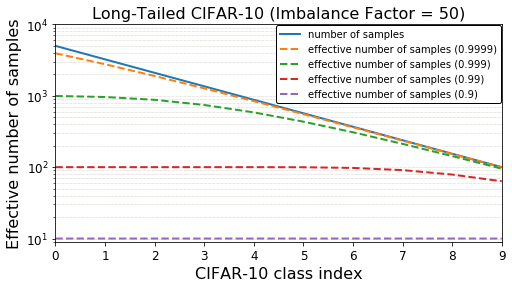

In [4]:
cls_num = 10
img_max = 5000
imb_factor = 0.02

img_num_per_cls = np.bincount(labels, minlength=10)
print(img_num_per_cls)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(img_num_per_cls, linewidth=2, label='number of samples')
for b in [0.9999, 0.999, 0.99, 0.9]:
    plt.plot((1.0 - np.power(b, img_num_per_cls)) / (1 - b), '--', linewidth=2, label='effective number of samples (%s)'%str(b))

plt.yscale('log')
ax.set_xticks(range(10))
ax.set_xticklabels(range(10))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.gca().grid(which='both', linestyle=':', linewidth='0.5', color='#a8a495')
plt.gca().xaxis.grid(False)
ax.set_xlim([0, 9])
ax.set_ylim([9, 10000])
leg = plt.legend(loc=0, borderaxespad=0.1, ncol=1, prop={'size':10}, edgecolor='k', framealpha=1.0)
ax.set_xlabel('CIFAR-10 class index', fontsize=16)
ax.set_ylabel('Effective number of samples', fontsize=16)
plt.title('Long-Tailed CIFAR-10 (Imbalance Factor = 50)', fontsize=16)
# plt.savefig('/home/yincui/Dropbox/balancedloss/cifar10_effec_num.pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)